In [331]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from scipy.stats import skew
from matplotlib.gridspec import GridSpec


In [332]:
# features = pd.read_csv("/kaggle/input/voice-features/features.csv")
# extra_features = pd.read_csv("/kaggle/input/voice-features/extracted_features_2k_3.csv")
# assert (features.columns == extra_features.columns).all() == True, 'mismatch in features'
# extra_features_v2 = pd.read_csv("/kaggle/input/voice-features-2/extracted_features_3k_v2.csv")
# assert (extra_features_v2.columns == extra_features.columns).all() == True, 'mismatch in features'
features = pd.read_csv("combined_20k.csv")
extra_features = pd.read_csv("fifties_b_1_4_7_10_12_16_17_20 (1).csv")
extra_1 = pd.read_csv("1k_male_twenties_b_5 (1).csv")
extra_2 = pd.read_csv("males_fifties_b7_11_14 (1).csv")
extra_3 = pd.read_csv("female_20_b_5_7_11_14 (1).csv")


In [333]:
def get_data_again():
    return pd.concat([features, extra_features, extra_1, extra_2, extra_3])

In [334]:
df = get_data_again()
#df = pd.read_csv("combined_40k.csv")
df = df.drop(columns = 'wps')


In [335]:
## remove duplicates
df = df.drop_duplicates()

In [336]:
def check_nulls(df):
    a = df.isna().sum()
    for index, value in a.items():
        if value > 0:
            return False
    return True

In [337]:
def smart_normalize(df, skew_threshold=0.5):

    numeric_cols = df.select_dtypes(include=['number']).columns
    df_normalized = df.copy()
    transformations = {}
    
    # Step 1: Skewness correction
    for col in numeric_cols:
        col_skew = skew(df[col].dropna())
        if abs(col_skew) > skew_threshold:
            # Apply Yeo-Johnson power transform (handles positive/negative values)
            pt = PowerTransformer(method='yeo-johnson')
            df_normalized[col] = pt.fit_transform(df[[col]]).flatten()
            transformations[col] = {
                'step1': 'power_transform',
                'skewness': col_skew,
                'transformer': pt
            }
        else:
            transformations[col] = {
                'step1': 'none',
                'skewness': col_skew
            }
    
    # Step 2: Standard scaling (applied to all numeric columns)
    scaler = StandardScaler()
    df_normalized[numeric_cols] = scaler.fit_transform(df_normalized[numeric_cols])
    transformations['_standard_scaler'] = scaler
    
    return df_normalized, transformations

In [338]:
def remove_outliers(df, outliers_cols, threshold_percent = 1):
    numeric_cols = df.select_dtypes(include=['number']).columns
    df_clean = df.copy()
    
    for i, (col, states) in enumerate(outliers_cols.items()):
        if states['percent'] < threshold_percent:
            lower_bound = states['lower_bound']
            upper_bound = states['upper_bound']
            
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        
    return df_clean

In [339]:
def find_high_outlier_columns(df):
    outlier_columns = {}
    
    for col in df.select_dtypes(include=np.number).columns:
        if col == 'age' or df[col].nunique() < 10:  
            continue
            
        Q1 = df[col].quantile(0.1)
        Q3 = df[col].quantile(0.9)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_percent = (len(outliers) / len(df[col].dropna())) * 100
        
        outlier_columns[col] = {
            'percent': outlier_percent,
            'count': len(outliers),
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
            
    return outlier_columns

In [340]:
def visualize_outliers(df, outlier_columns):
    if not outlier_columns:
        print("No columns with more than 5% outliers found.")
        return
    percent = -1
    for i, (col, stats) in enumerate(outlier_columns.items()):
        percent = max(percent, stats['percent'])
        if stats['percent'] > 5:
            plt.figure(figsize=(15, 8))
            gs = GridSpec(2, 2, height_ratios=[3, 1])
            
            # Box plot
            ax1 = plt.subplot(gs[0, 0])
            sns.boxplot(x=df[col], ax=ax1)
            ax1.set_title(f"Box Plot: {col}")
            
            # Histogram with KDE
            ax2 = plt.subplot(gs[0, 1])
            sns.histplot(df[col], kde=True, ax=ax2)
            ax2.axvline(stats['lower_bound'], color='r', linestyle='--', label='Outlier Threshold')
            ax2.axvline(stats['upper_bound'], color='r', linestyle='--')
            ax2.legend()
            ax2.set_title(f"Distribution: {col}")
            
            # Outlier detail table
            ax3 = plt.subplot(gs[1, :])
            ax3.axis('off')
            outlier_text = (
                f"Column: {col}\n"
                f"Outliers: {stats['count']} values ({stats['percent']:.2f}% of non-null data)\n"
                f"Lower bound: {stats['lower_bound']:.2f}\n"
                f"Upper bound: {stats['upper_bound']:.2f}\n"
                f"Min: {df[col].min():.2f}, Max: {df[col].max():.2f}\n"
                f"Mean: {df[col].mean():.2f}, Median: {df[col].median():.2f}"
            )
            ax3.text(0.5, 0.5, outlier_text, ha='center', va='center', fontsize=12)
            
            plt.tight_layout()
            plt.show()
            
            # Print summary
            print(f"\n📊 Outlier Analysis for {col}:")
            print(f"  • {stats['percent']:.2f}% of values are outliers ({stats['count']} out of {len(df[col].dropna())})")
            print(f"  • Outlier thresholds: < {stats['lower_bound']:.2f} or > {stats['upper_bound']:.2f}")
            print("──"*40)
    print("Max Percentage of Outliers: ", percent)

In [341]:
def view_outlier_dist(df, outlier_columns):
    for i, (col, stats) in enumerate(outlier_columns.items()):
        if stats['percent'] > 5:
            df_clean = df.copy()
            df = df_clean[(df_clean[col] >= stats['lower_bound']) & (df_clean[col] <= stats['upper_bound'])]
            
            male_df = df_clean[df_clean['gender'] == 'male']
            female_df = df_clean[df_clean['gender'] == 'female']
                
            male_stats = {'mean': male_df[col].mean(), 'std': male_df[col].std()}
            female_stats = {'mean': female_df[col].mean(), 'std': female_df[col].std()}
            
            male_snr = abs(male_stats['mean']) / male_stats['std'] if male_stats['std'] != 0 else 0
            female_snr = abs(female_stats['mean']) / female_stats['std'] if female_stats['std'] != 0 else 0
            
            pooled_std = np.sqrt((male_stats['std']**2 + female_stats['std']**2)/2)
            cohens_d = abs(male_stats['mean'] - female_stats['mean']) / pooled_std
            print(cohens_d)
            
            plt.figure(figsize=(12, 6))
            
            # Distribution plot
            sns.kdeplot(data=df_clean, x=col, hue='gender', fill=True, alpha=0.3, 
                       common_norm=False, palette={'male':'blue', 'female':'orange'}, hue_order=('male', 'female'))
            
            plt.axvline(male_stats['mean'], color='blue', linestyle='--', 
                        label=f"Male: μ = {male_stats['mean']:.2f}, σ = {male_stats['std']:.2f}")
            plt.axvline(female_stats['mean'], color='orange', linestyle='--',
                        label=f"Female: μ = {female_stats['mean']:.2f}, σ = {female_stats['std']:.2f}")
            
            plt.axvspan(male_stats['mean'] - male_stats['std'], male_stats['mean'] + male_stats['std'], 
                        color='blue', alpha=0.1)
            plt.axvspan(female_stats['mean'] - female_stats['std'], female_stats['mean'] + female_stats['std'],
                       color='orange', alpha=0.1)
            
            plt.title(f"{col}\nCohen's d = {cohens_d:.2f} (Male SNR: {male_snr:.2f}, Female SNR: {female_snr:.2f})")
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            # Print comprehensive comparison
            print(f"\n📊 {col}")
            print(f"   Male: μ/σ = {male_snr:.2f} (μ = {male_stats['mean']:.2f}, σ = {male_stats['std']:.2f})")
            print(f" Female: μ/σ = {female_snr:.2f} (μ = {female_stats['mean']:.2f}, σ = {female_stats['std']:.2f})")
            print(f" Standardized difference (Cohen's d): {cohens_d:.2f}")
            print("──"*30)

In [342]:
def plot_male_female_diff(male_df, female_df):
    for col in male_df.select_dtypes(include=np.number).columns:  # Only numeric columns
        if col == 'gender':
            continue
            
        male_stats = {'mean': male_df[col].mean(), 'std': male_df[col].std()}
        female_stats = {'mean': female_df[col].mean(), 'std': female_df[col].std()}
        
        male_snr = abs(male_stats['mean']) / male_stats['std'] if male_stats['std'] != 0 else 0
        female_snr = abs(female_stats['mean']) / female_stats['std'] if female_stats['std'] != 0 else 0
        
        pooled_std = np.sqrt((male_stats['std']**2 + female_stats['std']**2)/2)
        cohens_d = abs(male_stats['mean'] - female_stats['mean']) / pooled_std
        
        if cohens_d > 0.4:
            plt.figure(figsize=(12, 6))
            
            # Distribution plot
            sns.kdeplot(data=df, x=col, hue='gender', fill=True, alpha=0.3, 
                       common_norm=False, palette={'male':'blue', 'female':'orange'}, hue_order=('male', 'female'))
            
            plt.axvline(male_stats['mean'], color='blue', linestyle='--', 
                        label=f"Male: μ = {male_stats['mean']:.2f}, σ = {male_stats['std']:.2f}")
            plt.axvline(female_stats['mean'], color='orange', linestyle='--',
                        label=f"Female: μ = {female_stats['mean']:.2f}, σ = {female_stats['std']:.2f}")
            
            plt.axvspan(male_stats['mean'] - male_stats['std'], male_stats['mean'] + male_stats['std'], 
                        color='blue', alpha=0.1)
            plt.axvspan(female_stats['mean'] - female_stats['std'], female_stats['mean'] + female_stats['std'],
                       color='orange', alpha=0.1)
            
            plt.title(f"{col}\nCohen's d = {cohens_d:.2f} (Male SNR: {male_snr:.2f}, Female SNR: {female_snr:.2f})")
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            # Print comprehensive comparison
            print(f"\n📊 {col}")
            print(f"   Male: μ/σ = {male_snr:.2f} (μ = {male_stats['mean']:.2f}, σ = {male_stats['std']:.2f})")
            print(f" Female: μ/σ = {female_snr:.2f} (μ = {female_stats['mean']:.2f}, σ = {female_stats['std']:.2f})")
            print(f" Standardized difference (Cohen's d): {cohens_d:.2f}")
            print("──"*30)

In [343]:
def plot_twenties_vs_fifties(twenties_df, fifties_df):
    for col in twenties_df.select_dtypes(include=np.number).columns:  
        if col == 'age':  
            continue
            
        # Calculate statistics
        twenties_stats = {'mean': twenties_df[col].mean(), 'std': twenties_df[col].std()}
        fifties_stats = {'mean': fifties_df[col].mean(), 'std': fifties_df[col].std()}
        
        # Calculate signal-to-noise ratio (mean/std)
        twenties_snr = abs(twenties_stats['mean']) / twenties_stats['std'] if twenties_stats['std'] != 0 else 0
        fifties_snr = abs(fifties_stats['mean']) / fifties_stats['std'] if fifties_stats['std'] != 0 else 0
        
        # Calculate standardized mean difference (Cohen's d)
        pooled_std = np.sqrt((twenties_stats['std']**2 + fifties_stats['std']**2)/2)
        cohens_d = abs(twenties_stats['mean'] - fifties_stats['mean']) / pooled_std
        
        # Only plot if substantial difference exists (Cohen's d > 0.4 effect)
        if cohens_d > 0.2:
            plt.figure(figsize=(12, 6))
            
            # Create temp dataframe with age groups for plotting
            plot_df = pd.concat([
                twenties_df[col].to_frame().assign(age_group='20-29'),
                fifties_df[col].to_frame().assign(age_group='50-59')
            ])
            
            # Distribution plot
            sns.kdeplot(data=plot_df, x=col, hue='age_group', fill=True, alpha=0.3, 
                       common_norm=False, palette={'20-29':'blue', '50-59':'orange'})
            
            # Add statistics annotations
            plt.axvline(twenties_stats['mean'], color='blue', linestyle='--', 
                        label=f"twenties: μ = {twenties_stats['mean']:.2f}, σ = {twenties_stats['std']:.2f}")
            plt.axvline(fifties_stats['mean'], color='orange', linestyle='--',
                        label=f"fifties: μ = {fifties_stats['mean']:.2f}, σ = {fifties_stats['std']:.2f}")
            
            # Add std ranges
            plt.axvspan(twenties_stats['mean'] - twenties_stats['std'], twenties_stats['mean'] + twenties_stats['std'], 
                        color='blue', alpha=0.1)
            plt.axvspan(fifties_stats['mean'] - fifties_stats['std'], fifties_stats['mean'] + fifties_stats['std'],
                       color='orange', alpha=0.1)
            
            plt.title(f"{col}\nCohen's d = {cohens_d:.2f} (twenties SNR: {twenties_snr:.2f}, fifties SNR: {fifties_snr:.2f})")
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            # Print comprehensive comparison
            print(f"\n📊 {col}")
            print(f"   twenties: μ/σ = {twenties_snr:.2f} (μ = {twenties_stats['mean']:.2f}, σ = {twenties_stats['std']:.2f})")
            print(f"   fifties: μ/σ = {fifties_snr:.2f} (μ = {fifties_stats['mean']:.2f}, σ = {fifties_stats['std']:.2f})")
            print(f"   Standardized difference (Cohen's d): {cohens_d:.2f}")
            print("──"*30)

In [344]:
def plot_age_gender_dist(twenties_df, fifties_df):
    for col in twenties_df.select_dtypes(include=np.number).columns:
        if col == 'age':
            continue
            
        # Create subsets for each demographic group
        male_20 = twenties_df[twenties_df['gender'] == 'male'][col].dropna()
        male_50 = fifties_df[fifties_df['gender'] == 'male'][col].dropna()
        female_20 = twenties_df[twenties_df['gender'] == 'female'][col].dropna()
        female_50 = fifties_df[fifties_df['gender'] == 'female'][col].dropna()
        
        # Calculate all Cohen's d comparisons
        def calculate_cohens_d(group1, group2):
            pooled_std = np.sqrt((group1.std()**2 + group2.std()**2)/2)
            return abs(group1.mean() - group2.mean()) / pooled_std
        
        cohens_d = {
            'male_vs_female_20': calculate_cohens_d(male_20, female_20),
            'male_vs_female_50': calculate_cohens_d(male_50, female_50),
            'age_effect_male': calculate_cohens_d(male_20, male_50),
            'age_effect_female': calculate_cohens_d(female_20, female_50)
        }
        
        # Only plot if any comparison shows meaningful effect size
        if any(d > 0.2 for d in cohens_d.values()):
            plt.figure(figsize=(14, 7))
            
            # Create plot dataframe
            plot_df = pd.concat([
                male_20.to_frame().assign(group='Male 20-29'),
                male_50.to_frame().assign(group='Male 50-59'),
                female_20.to_frame().assign(group='Female 20-29'),
                female_50.to_frame().assign(group='Female 50-59')
            ])
            
            # Plot KDE
            palette = {'Male 20-29':'blue', 'Male 50-59':'lightblue',
                     'Female 20-29':'red', 'Female 50-59':'orange'}
            
            for group, color in palette.items():
                group_data = plot_df[plot_df['group'] == group]
                sns.kdeplot(data=group_data, x=col, color=color, 
                            fill=True, alpha=0.2, common_norm=False, 
                            linewidth=2, label=group)
            
            # Add effect size annotations
            text_y = 0.9
            for name, d in cohens_d.items():
                if d > 0.2:
                    comp_name = name.replace('_', ' ').title()
                    plt.text(0.02, text_y, f"{comp_name}: Cohen's d = {d:.2f}",
                            transform=plt.gca().transAxes, fontsize=10,
                            bbox=dict(facecolor='white', alpha=0.7))
                    text_y -= 0.08
            
            plt.title(f"Distribution of {col}\n(Only showing comparisons with Cohen's d > 0.2)")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()
            
            # Print detailed statistics
            print(f"\n📊 {col} - Effect Size Analysis:")
            print(f"  Male 20s vs Female 20s: d = {cohens_d['male_vs_female_20']:.2f}")
            print(f"  Male 50s vs Female 50s: d = {cohens_d['male_vs_female_50']:.2f}")
            print(f"  Age Effect (Male 20s vs 50s): d = {cohens_d['age_effect_male']:.2f}")
            print(f"  Age Effect (Female 20s vs 50s): d = {cohens_d['age_effect_female']:.2f}")
            print("──"*40)

In [345]:
def duration_plot(male_df, female_df):
    # Calculate statistics
    twenties_stats = {'mean': male_df['duration'].mean(), 'std': male_df['duration'].std()}
    fifties_stats = {'mean': female_df['duration'].mean(), 'std': female_df['duration'].std()}
    
    # Calculate signal-to-noise ratio (mean/std)
    twenties_snr = abs(twenties_stats['mean']) / twenties_stats['std'] if twenties_stats['std'] != 0 else 0
    fifties_snr = abs(fifties_stats['mean']) / fifties_stats['std'] if fifties_stats['std'] != 0 else 0
    
    # Calculate standardized mean difference (Cohen's d)
    pooled_std = np.sqrt((twenties_stats['std']**2 + fifties_stats['std']**2)/2)
    cohens_d = abs(twenties_stats['mean'] - fifties_stats['mean']) / pooled_std
    
    plt.figure(figsize=(12, 6))
    
    # Create temp dataframe with age groups for plotting
    plot_df = pd.concat([
        twenties_df['duration'].to_frame().assign(age_group='20-29'),
        fifties_df['duration'].to_frame().assign(age_group='50-59')
    ])
    
    # Distribution plot
    sns.kdeplot(data=plot_df, x='duration', hue='age_group', fill=True, alpha=0.3, 
               common_norm=False, palette={'20-29':'blue', '50-59':'orange'})
    
    # Add statistics annotations
    plt.axvline(twenties_stats['mean'], color='blue', linestyle='--', 
                label=f"twenties: μ = {twenties_stats['mean']:.2f}, σ = {twenties_stats['std']:.2f}")
    plt.axvline(fifties_stats['mean'], color='orange', linestyle='--',
                label=f"fifties: μ = {fifties_stats['mean']:.2f}, σ = {fifties_stats['std']:.2f}")
    
    # Add std ranges
    plt.axvspan(twenties_stats['mean'] - twenties_stats['std'], twenties_stats['mean'] + twenties_stats['std'], 
                color='blue', alpha=0.1)
    plt.axvspan(fifties_stats['mean'] - fifties_stats['std'], fifties_stats['mean'] + fifties_stats['std'],
               color='orange', alpha=0.1)
    
    plt.title(f"{col}\nCohen's d = {cohens_d:.2f} (twenties SNR: {twenties_snr:.2f}, fifties SNR: {fifties_snr:.2f})")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive comparison
    print(f"\n📊 duration")
    print(f"   twenties: μ/σ = {twenties_snr:.2f} (μ = {twenties_stats['mean']:.2f}, σ = {twenties_stats['std']:.2f})")
    print(f"   fifties: μ/σ = {fifties_snr:.2f} (μ = {fifties_stats['mean']:.2f}, σ = {fifties_stats['std']:.2f})")
    print(f"   Standardized difference (Cohen's d): {cohens_d:.2f}")
    print("──"*30)

In [346]:
def analyze_feature_correlations(df, threshold=0.5):
    
    numeric_df = df.select_dtypes(include=['number'])
    
    corr_matrix = numeric_df.corr()
    
    # Find high correlations
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                 corr_matrix.iloc[i, j]))
    return high_corr

In [347]:
def features_to_keep(all_features, corr_features, to_be_removed):
    features_set = set()
    to_keep = []
    for removed in to_be_removed:
        features_set.add(removed)
    
    for x, y, z in corr_features:
        if x not in features_set and y not in features_set:
            to_keep.append(x)
            features_set.add(x)
            features_set.add(y)

    for feature in all_features:
        if feature not in features_set:
            to_keep.append(feature)

    return to_keep

## Calls

/var/folders/2q/6vjsrj112rb774fzn79lb71h0000gn/T/ipykernel_14073/1630797517.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


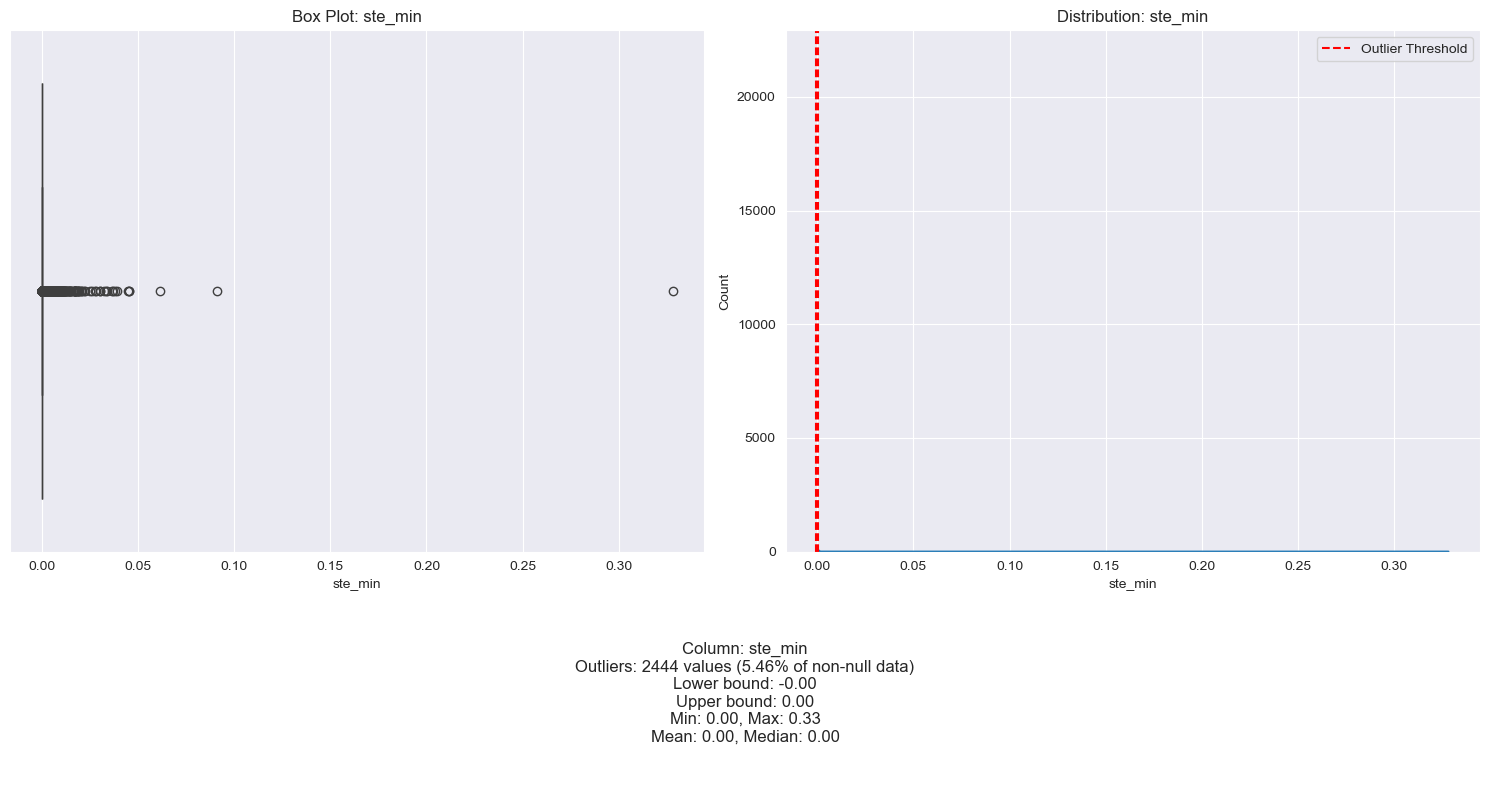


📊 Outlier Analysis for ste_min:
  • 5.46% of values are outliers (2444 out of 44777)
  • Outlier thresholds: < -0.00 or > 0.00
────────────────────────────────────────────────────────────────────────────────
Max Percentage of Outliers:  5.45815932286665


In [54]:
outliers_cols = find_high_outlier_columns(df)
visualize_outliers(df, outliers_cols)

0.07793571612441193


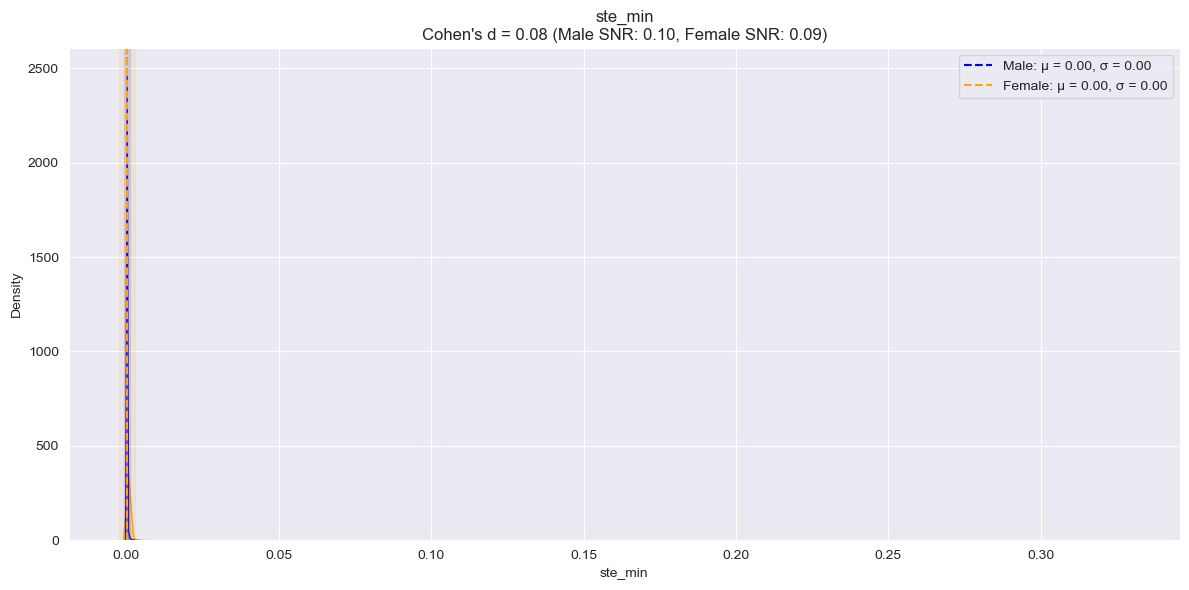


📊 ste_min
   Male: μ/σ = 0.10 (μ = 0.00, σ = 0.00)
 Female: μ/σ = 0.09 (μ = 0.00, σ = 0.00)
 Standardized difference (Cohen's d): 0.08
────────────────────────────────────────────────────────────


In [55]:
view_outlier_dist(df, outliers_cols)

In [350]:
#save means of df in a dataframe only number
means_df = df.drop(columns = ['gender', 'age'])
means_df = means_df.mean().to_frame().T
means_df = means_df.rename(columns = lambda x: x + '_mean')
means_df = means_df.rename_axis('index').reset_index()
means_df.to_csv('Inference/means.csv', index=False)

In [319]:
#replace null with mean
for col in df.select_dtypes(include=['number']).columns:
    if df[col].isnull().sum() > 0:
        print(f"Column: {col}, Nulls: {df[col].isnull().sum()}")
        mean_value = df[col].mean()
        df[col] = df[col].fillna(mean_value)

Column: f0_mean, Nulls: 1
Column: f0_std, Nulls: 1
Column: f0_5_percentile, Nulls: 1
Column: f0_95_percentile, Nulls: 1
Column: formant3, Nulls: 2


In [320]:
assert check_nulls(df) == True, 'there are nulls'

In [287]:
## commented gd3na mn 3ndy
# df_normalized, transformations = smart_normalize(df)
# outliers_cols = find_high_outlier_columns(df_normalized)
# # df_normalized = remove_outliers(df_normalized, outliers_cols)
# df = df_normalized.copy()

In [321]:
male_df = df[df['gender'] == 'male']
female_df = df[df['gender'] == 'female']
twenties_df = df[df['age'] == 'twenties']
fifties_df = df[df['age'] == 'fifties']

In [322]:
correlated_features = analyze_feature_correlations(df, 0.8)

In [324]:
remaining_features = features_to_keep(df.select_dtypes(include=['number']).columns, correlated_features, to_be_removed=['duration'])
## save remaining features in a json so i can remove others
import json
with open('./Inference/remaining_features.json', 'w') as f:
    json.dump(remaining_features, f)
remaining_features.append('age')
remaining_features.append('gender')

In [325]:
assert len(remaining_features) == len(set(remaining_features)), 'problem in feature selection'
print(len(remaining_features), len(df))
df = df[remaining_features]

105 39433


## Baseline Model

In [326]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA

In [327]:
def normalize_test(X_test, transformations):
    X_test_normalized = X_test.copy()
    for col, info in transformations.items():
        if col == '_standard_scaler':
            continue
        if info['step1'] == 'power_transform':
            pt = info['transformer']
            X_test_normalized[col] = pt.transform(X_test[[col]]).flatten()

    # Apply standard scaling using the saved scaler
    scaler = transformations['_standard_scaler']
    numeric_cols = X_test.select_dtypes(include=['number']).columns
    X_test_normalized[numeric_cols] = scaler.transform(X_test_normalized[numeric_cols])
    return X_test_normalized


In [328]:
from xgboost import XGBClassifier
def baseline(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, transformations = smart_normalize(X_train)
    X_test = normalize_test(X_test, transformations)
    clf = XGBClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return clf.feature_importances_

In [329]:
X = df.drop(['gender', 'age'], axis=1)
y = df['gender'].map({'male' : 1, 'female' : 0}) + 2 * df['age'].map({'twenties' : 1, 'fifties' : 0})

In [296]:
baseline(X, y)

Accuracy: 0.7869796761221607
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      2147
           1       0.77      0.83      0.80      2351
           2       0.82      0.86      0.84      2688
           3       0.74      0.67      0.70      2015

    accuracy                           0.79      9201
   macro avg       0.78      0.78      0.78      9201
weighted avg       0.79      0.79      0.79      9201



array([0.03132178, 0.00920366, 0.01093969, 0.00913273, 0.00870064,
       0.00575784, 0.00816216, 0.00892542, 0.0085861 , 0.01428993,
       0.00618162, 0.00731002, 0.0052025 , 0.00508881, 0.01471408,
       0.14087726, 0.06862343, 0.00750758, 0.00444099, 0.00407887,
       0.00414257, 0.00961888, 0.00931175, 0.01413152, 0.01065622,
       0.01223768, 0.01889939, 0.01283516, 0.01317479, 0.01406767,
       0.01468322, 0.01142878, 0.00825831, 0.01311446, 0.00707747,
       0.01047058, 0.01396836, 0.00708208, 0.00616575, 0.00766587,
       0.00689249, 0.00569321, 0.01197857, 0.00475522, 0.00445007,
       0.0121076 , 0.00599448, 0.0052064 , 0.00652492, 0.00503895,
       0.00525117, 0.00547438, 0.0046465 , 0.00696039, 0.00530778,
       0.00472001, 0.00419536, 0.00443766, 0.00432752, 0.00472362,
       0.00457611, 0.00446132, 0.00468915, 0.0047487 , 0.006474  ,
       0.00420012, 0.01499268, 0.00824096, 0.00636283, 0.0096632 ,
       0.00593099, 0.00487257, 0.00511948, 0.00550229, 0.00685

In [297]:
pca = PCA(n_components=90)  
X_pca = pca.fit_transform(X)  

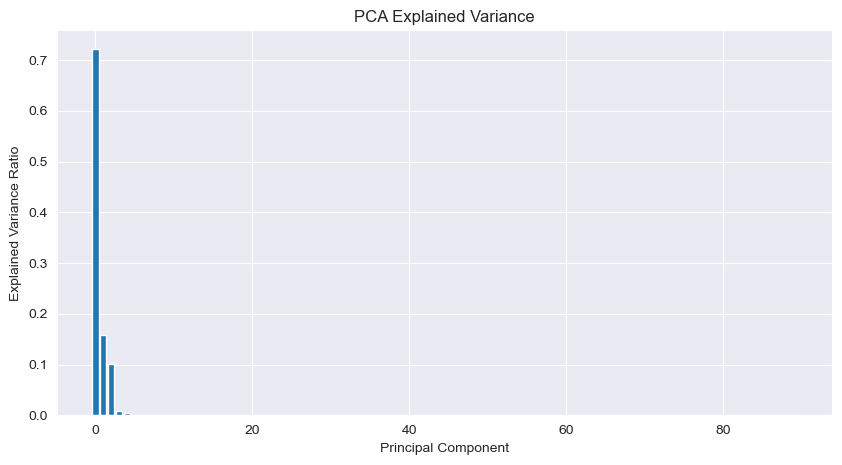

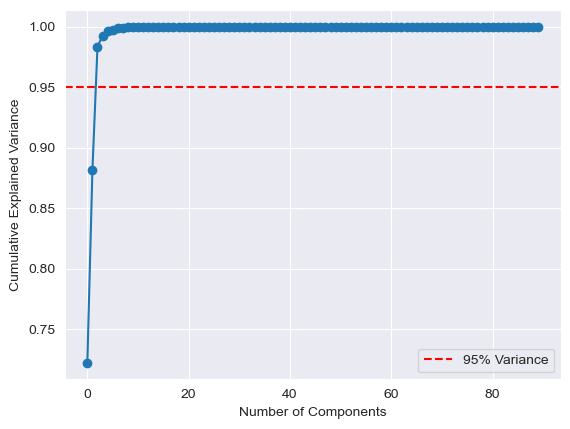

In [298]:
plt.figure(figsize=(10, 5))
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.show()

In [299]:
baseline(X, y)

Accuracy: 0.7869796761221607
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      2147
           1       0.77      0.83      0.80      2351
           2       0.82      0.86      0.84      2688
           3       0.74      0.67      0.70      2015

    accuracy                           0.79      9201
   macro avg       0.78      0.78      0.78      9201
weighted avg       0.79      0.79      0.79      9201



array([0.03132178, 0.00920366, 0.01093969, 0.00913273, 0.00870064,
       0.00575784, 0.00816216, 0.00892542, 0.0085861 , 0.01428993,
       0.00618162, 0.00731002, 0.0052025 , 0.00508881, 0.01471408,
       0.14087726, 0.06862343, 0.00750758, 0.00444099, 0.00407887,
       0.00414257, 0.00961888, 0.00931175, 0.01413152, 0.01065622,
       0.01223768, 0.01889939, 0.01283516, 0.01317479, 0.01406767,
       0.01468322, 0.01142878, 0.00825831, 0.01311446, 0.00707747,
       0.01047058, 0.01396836, 0.00708208, 0.00616575, 0.00766587,
       0.00689249, 0.00569321, 0.01197857, 0.00475522, 0.00445007,
       0.0121076 , 0.00599448, 0.0052064 , 0.00652492, 0.00503895,
       0.00525117, 0.00547438, 0.0046465 , 0.00696039, 0.00530778,
       0.00472001, 0.00419536, 0.00443766, 0.00432752, 0.00472362,
       0.00457611, 0.00446132, 0.00468915, 0.0047487 , 0.006474  ,
       0.00420012, 0.01499268, 0.00824096, 0.00636283, 0.0096632 ,
       0.00593099, 0.00487257, 0.00511948, 0.00550229, 0.00685

In [301]:
X = df.drop(['gender', 'age'], axis=1)
y = df['age'].map({'twenties' : 1, 'fifties' : 0})
#y = df['gender'].map({'male': 1, 'female': 0})
baseline(X, y)

Accuracy: 0.778937072057385
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      4498
           1       0.79      0.77      0.78      4703

    accuracy                           0.78      9201
   macro avg       0.78      0.78      0.78      9201
weighted avg       0.78      0.78      0.78      9201



array([0.01502484, 0.00968039, 0.02077134, 0.01118281, 0.01366196,
       0.00832681, 0.00882053, 0.00989781, 0.00950232, 0.01808101,
       0.00712385, 0.00909818, 0.00667575, 0.00673088, 0.01720071,
       0.01689002, 0.0290917 , 0.01035147, 0.00577155, 0.0062541 ,
       0.00476544, 0.01128783, 0.0236465 , 0.0168488 , 0.01098632,
       0.01458475, 0.01938896, 0.01443402, 0.01670662, 0.0148726 ,
       0.01786545, 0.01496397, 0.00984876, 0.01653033, 0.00817682,
       0.01176032, 0.00755452, 0.00826896, 0.00725648, 0.00988056,
       0.00897957, 0.00732914, 0.02228016, 0.00706883, 0.00600176,
       0.01387161, 0.00770334, 0.00688433, 0.00979015, 0.00571499,
       0.00681124, 0.00796369, 0.00653228, 0.01048465, 0.00705935,
       0.00629301, 0.00687183, 0.00542108, 0.005245  , 0.00674602,
       0.00552333, 0.00575736, 0.00543005, 0.00775208, 0.00662404,
       0.00425978, 0.02602791, 0.00801085, 0.00731543, 0.01007117,
       0.00840511, 0.0076105 , 0.00665728, 0.00559644, 0.00925

In [330]:
df.to_csv('./cleaned_without.csv', index=False)

0
2    11827
0    11671
3    10935
1    10344
Name: count, dtype: int64
(44777, 107)


/var/folders/2q/6vjsrj112rb774fzn79lb71h0000gn/T/ipykernel_14073/1593603952.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=classes, data=df, palette='Set2')


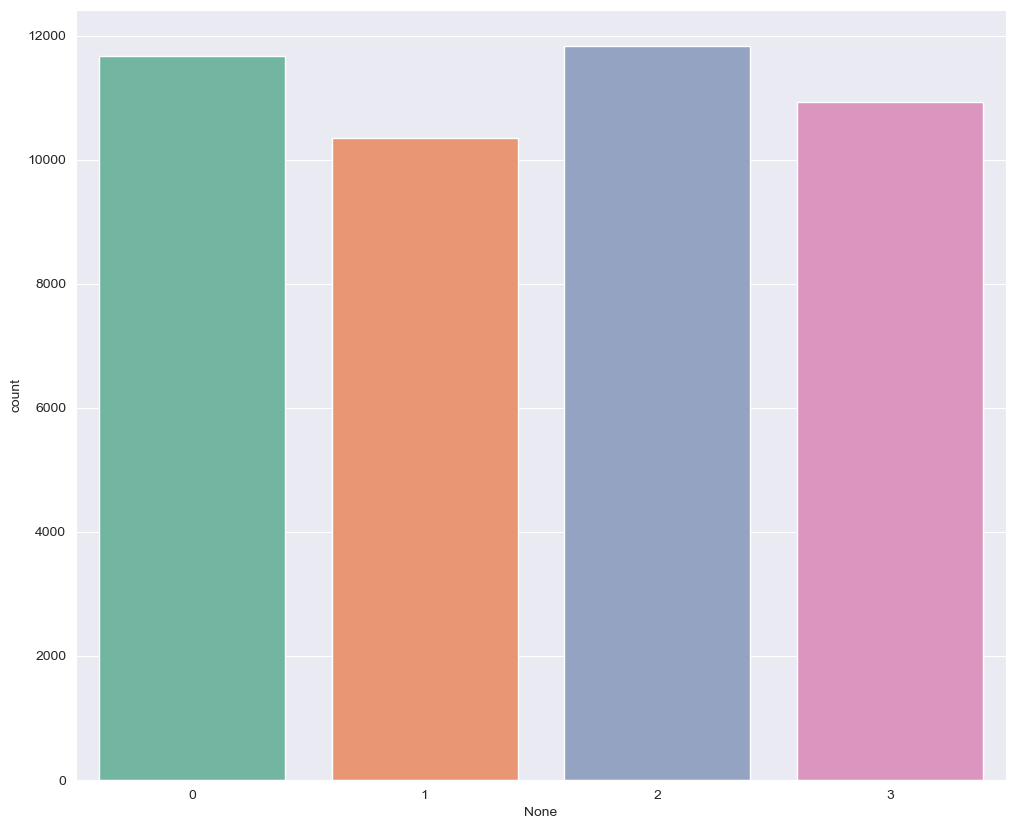

In [36]:
files = ["cleaned.csv"]
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
df = pd.concat(dfs, axis=0)
df['gender'].value_counts()
df['age'].value_counts()
## check for duplicates in the dataset
duplicates = df.duplicated()
duplicates_count = duplicates.sum()
print(duplicates_count)
plt.figure(figsize=(12, 10))
df['gender'] = df['gender'].map({'male': 0, 'female': 1, 0:0, 1:1})
df['age'] = df['age'].map({'twenties': 0, 'fifties': 1, 0:0, 1:1})
classes = df['gender'].copy() + 2 * df['age'].copy()
print(classes.value_counts())
sns.countplot(x=classes, data=df, palette='Set2')
print(df.shape)